## Autoencoder to detect anomalies

The objective of this project is to create a Machine Learning Model that will be able to <b>detect anomalies in objects with a focus on industrial inspection</b>. The end goal is to train a model able to detect abnormal industrial objects.

The approach we will be using is an autoencoder for anomaly detection. The autoenconder is be basically a neural network that has the same number of neurons in the input and in the output layers, but a smaller number of neurons in the hidden layers. The idea is to train the autoencoder only with normal samples, and then try to reconstruct the original input in the output layer. The autoencoder should decompose the input in the hidden layers to learn what the normal samples look like, and after training it should be a reliable autoencoder in which the error between its inputs (original images) and outputs (reconstructed image) is smaller in the normal samples and bigger in the abnormal ones.

We will use a database which is available at https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads. MVTec AD is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over 5000 high-resolution images divided into fifteen different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects. For this work, we will initially focus only in the <b>bottles</b> category, but the code can is generalized for any other product in this same database.

This notebook was created inspired in these articles:<br>
https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1<br>
https://medium.com/analytics-vidhya/preprocess-image-data-for-machine-learning-37df531583d8<br>
https://www.tensorflow.org/tutorials/generative/autoencoder?hl=en

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Exploratory Data Analysis
First we will take a look into one sample of this dataset and see what it looks like, so we can have an idea of what kind of preprocessing on the images we need to do

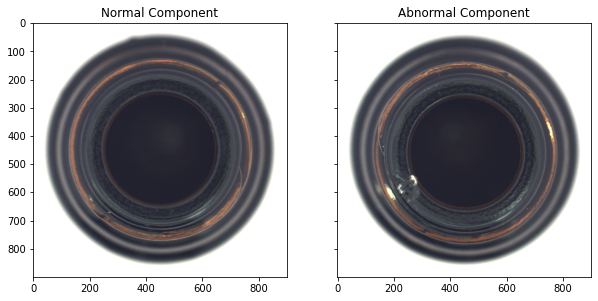

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

normal_image = mpimg.imread(r'/content/drive/MyDrive/Colab Notebooks/bottle/train/good/000.png')
abnormal_image = mpimg.imread(r'/content/drive/MyDrive/Colab Notebooks/bottle/test/broken_small/000.png')

# Visualize the data.
fig, (normal_ax, abnormal_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
normal_ax.imshow(normal_image)
normal_ax.set_title("Normal Component")

abnormal_ax.imshow(abnormal_image)
abnormal_ax.set_title("Abnormal Component")

plt.show()

In [3]:
import pandas as pd

#Checking the image resolution and number of channels
print('Dimension of the image: ', normal_image.shape)

#Checking the range of the channels
print('Descriptive statistics of the image:')
print(pd.Series(normal_image.reshape(-1)).describe())

Dimension of the image:  (900, 900, 3)
Descriptive statistics of the image:
count    2.430000e+06
mean     5.367402e-01
std      3.601842e-01
min      1.137255e-01
25%      2.235294e-01
50%      3.411765e-01
75%      1.000000e+00
max      1.000000e+00
dtype: float64


### Preprocessing of images

The current dimension of the image file might be too large to feed an efficient neural network given the limited amount of resources that we have. We will try to first reduce the dimension of the images as the only preprocessing step.

The pixels are normalized between 0 and 1 values, which will help to make our computations more efficient, hence we won't do any normalization.

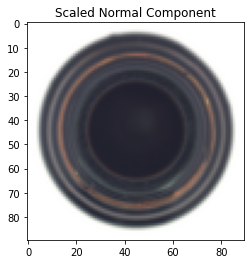

In [4]:
from skimage.transform import resize

normal_image_rescaled = resize(normal_image, (90, 90) , anti_aliasing=True)

plt.title("Scaled Normal Component")
plt.imshow(normal_image_rescaled)

In [5]:
#Checking the image resolution and number of channels
print('Dimension of the image: ', normal_image_rescaled.shape)

#Checking the range of the channels
print('Descriptive statistics of the image:')
print(pd.Series(normal_image_rescaled.reshape(-1)).describe())

Dimension of the image:  (90, 90, 3)
Descriptive statistics of the image:
count    24300.000000
mean         0.536738
std          0.356568
min          0.125403
25%          0.233926
50%          0.339630
75%          1.000000
max          1.000000
dtype: float64


This new image doesn't look optimal due to the dimensionality reduction, but given the limited resources that we have for training, we will try to train our model with these preprocessed images. We will then create the preprocessing functions

In [6]:
from os import listdir
from os.path import isfile, join
import numpy as np
import torch

preprocess_height = 90
preprocess_width = 90

def get_preprocessed_1d_array_from_image(image):
    image_rescaled = resize(image, (preprocess_height, preprocess_width) , anti_aliasing=True)
    return image_rescaled.reshape(-1)

def get_preprocessed_images_from_dir(dir):
    files = [f for f in listdir(dir) if isfile(join(dir, f))]
    dataset = []
    for file in files:
        image = mpimg.imread(dir + file)
        preprocessed_image = get_preprocessed_1d_array_from_image(image)
        dataset.append(preprocessed_image)
    return torch.tensor(np.array(dataset), dtype=torch.float32)

def get_image_from_preprocessed(tensor):
    return tensor.numpy().reshape(preprocess_height, preprocess_width, 3)

### Loading the dataset into Pytorch

In [7]:
#We will use our preprocessing functions to get the peprocessed images in the train set
preprocessed_images_train = get_preprocessed_images_from_dir(r'/content/drive/MyDrive/Colab Notebooks/bottle/train/good/')

#Checking the image resolution and number of channels
print('Dimension of the train preprocessed data: ', preprocessed_images_train.shape)

#Checking the range of the channels
print('Descriptive statistics of the first normal image, which should be the same we saw in the EDA section:')
print(pd.Series(preprocessed_images_train[0]).describe())

Dimension of the train preprocessed data:  torch.Size([209, 24300])
Descriptive statistics of the first normal image, which should be the same we saw in the EDA section:
count    24300.000000
mean         0.527907
std          0.362910
min          0.122835
25%          0.217030
50%          0.320984
75%          1.000000
max          1.000000
dtype: float64


In [8]:
#Now that we verified our preprocessing functions work, we will get the remaining datasets
preprocessed_images_test_good          = get_preprocessed_images_from_dir(r'/content/drive/MyDrive/Colab Notebooks/bottle/test/good/')
preprocessed_images_test_broken_small  = get_preprocessed_images_from_dir(r'/content/drive/MyDrive/Colab Notebooks/bottle/test/broken_small/')
preprocessed_images_test_broken_large  = get_preprocessed_images_from_dir(r'/content/drive/MyDrive/Colab Notebooks/bottle/test/broken_large/')
preprocessed_images_test_contamination = get_preprocessed_images_from_dir(r'/content/drive/MyDrive/Colab Notebooks/bottle/test/contamination/')

In [9]:
from torch.utils.data import Dataset, DataLoader

class IndustrialComponentsDataset(Dataset):
    
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [10]:
batch_size=1

dataloader_train = DataLoader(IndustrialComponentsDataset(preprocessed_images_train),
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)

dataloader_test_good = DataLoader(IndustrialComponentsDataset(preprocessed_images_test_good),
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)

dataloader_test_broken_small = DataLoader(IndustrialComponentsDataset(preprocessed_images_test_broken_small),
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)

dataloader_test_broken_large = DataLoader(IndustrialComponentsDataset(preprocessed_images_test_broken_large),
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)

dataloader_test_contamination = DataLoader(IndustrialComponentsDataset(preprocessed_images_test_contamination),
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)

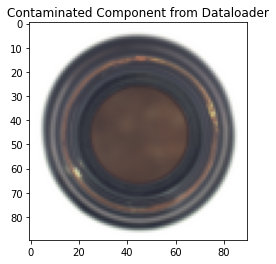

In [11]:
#Just to verify how a contaminated bottle looks like directly from our dataloader
plt.title("Contaminated Component from Dataloader")
plt.imshow(get_image_from_preprocessed(next(iter(dataloader_test_contamination))))

### Creating the autoencoder

In [12]:
import torch
from torch import nn
from torch import functional
from torch import tensor

input_dim  = preprocess_height * preprocess_width * 3 #Number of channels
latent_dim = 256

class NeuralNet(nn.Module):

  def __init__(self):
    super(NeuralNet, self).__init__()
    self.input_layer  = nn.Linear(input_dim, latent_dim)
    self.hidden_layer = nn.Linear(latent_dim, input_dim)
    
  def forward(self, X):
    X = nn.functional.leaky_relu(self.input_layer(X))
    X = nn.functional.leaky_relu(self.hidden_layer(X))
    return X

In [13]:
# Relevant if you have a GPU:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
autoencoder = NeuralNet().to(device) # create neural net

### Training the autoencoder

In [14]:
from tqdm import tqdm  # For progress bars
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

def train(model, ldr_train, me, lr):
    # network, loader_train, max_epochs,lerning_rate
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr)
    progress_bar = tqdm(range(me * (len(ldr_train))))
    loss_hist_train = []
    for epoch in range(me):
        epoch_loss_train = 0
        
        model.train()
        for image_tensor in ldr_train:
            image_tensor = image_tensor.to(device)
            optimizer.zero_grad()
            output = model.forward(image_tensor)
            loss = loss_fn(output, image_tensor)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()
            progress_bar.update(1)
        loss_hist_train.append(epoch_loss_train)
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.plot(loss_hist_train, label='Train Loss')    
    plt.legend()

  0%|          | 0/4180 [00:00<?, ?it/s]

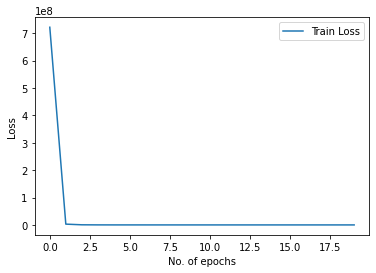

In [15]:
#After doing multiple tests, it seems like 20 epochs is a good number since the train error starts to increase after ~20 epochs
max_epochs = 20
lrn_rate = .1

train(autoencoder, dataloader_train, max_epochs, lrn_rate)

### Testing and results

Now we will check how well our model is performing. First we will check what the reconstructed images in the test set look like when comparing the original inputs.

We will then get the average and standard deviation of the errors in the (training) normal samples. This will allow us to estimate which inputs generate outputs with errors greater than the "normal" errors and classify those as abnormal.

In [16]:
def get_reconstructed_images(model, dataloader):
    model.eval()
    loss_fn = torch.nn.MSELoss()
    original_images = []
    reconstructed_images = []
    errors = []
    with torch.no_grad():
        for original_image in dataloader:
            original_image = original_image.to(device)
            reconstructed_image = model(original_image)

            error = loss_fn(original_image, reconstructed_image).item()
            errors.append(error)

            original_image = get_image_from_preprocessed(original_image.cpu())            
            reconstructed_image = get_image_from_preprocessed(reconstructed_image.cpu())            
            original_images.append(original_image)
            reconstructed_images.append(reconstructed_image)
    return (original_images, reconstructed_images), errors

In [17]:
(original_images_train, reconstructed_images_train), error_images_train = get_reconstructed_images(autoencoder, dataloader_train)

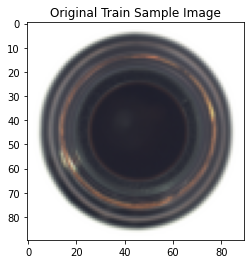

In [18]:
plt.title("Original Train Sample Image")
plt.imshow(original_images_train[0])

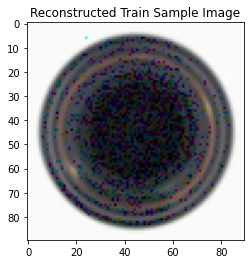

In [19]:
plt.title("Reconstructed Train Sample Image")
plt.imshow(reconstructed_images_train[0])

In [20]:
#Get the descriptive statistics of the errors of the original images vs reconstructed images, so we can see what is the mean 
#and standard deviation of the errors and use them to classify as abnormal any sample that is farther than one standard deviation
#from the mean
train_error_statistics = pd.Series(error_images_train).describe()
print(train_error_statistics)

count    209.000000
mean       0.007778
std        0.002870
min        0.005467
25%        0.006293
50%        0.006878
75%        0.008248
max        0.029902
dtype: float64


In [21]:
def predict(model, dataloader):
  error_mean = train_error_statistics[1] #Gotten from the errors of the training set
  error_std  = train_error_statistics[2] #Gotten from the errors of the training set
  loss_fn = torch.nn.MSELoss()
  predictions = []
  for original_image in dataloader:
    original_image = original_image.to(device)
    reconstructed_image = model(original_image)
    loss = loss_fn(reconstructed_image, original_image).item()
    predictions.append(1 if loss > error_mean + error_std or loss < error_mean - error_std else 0)
  return predictions    

In [22]:
predictions_train = predict(autoencoder, dataloader_train)
predictions_test_good = predict(autoencoder, dataloader_test_good)
predictions_test_broken_small = predict(autoencoder, dataloader_test_broken_small)
predictions_test_broken_large = predict(autoencoder, dataloader_test_broken_large)
predictions_test_contamination = predict(autoencoder, dataloader_test_contamination)

### Conclusion

In [23]:
print('Percentage of samples considered abnormal in set train (lower is better) {:.2f}%'.format(100 * (sum(predictions_train) / len(predictions_train))))
print('Percentage of samples considered abnormal in set test good (lower is better) {:.2f}%'.format(100 * (sum(predictions_test_good) / len(predictions_test_good))))
print('Percentage of samples considered abnormal in set test broken small (higher is better) {:.2f}%'.format(100 * (sum(predictions_test_broken_small) / len(predictions_test_broken_small))))
print('Percentage of samples considered abnormal in set test broken large (higher is better) {:.2f}%'.format(100 * (sum(predictions_test_broken_large) / len(predictions_test_broken_large))))
print('Percentage of samples considered abnormal in set test contamination (higher is better) {:.2f}%'.format(100 * (sum(predictions_test_contamination) / len(predictions_test_contamination))))

Percentage of samples considered abnormal in set train (lower is better) 7.66%
Percentage of samples considered abnormal in set test good (lower is better) 10.00%
Percentage of samples considered abnormal in set test broken small (higher is better) 22.73%
Percentage of samples considered abnormal in set test broken large (higher is better) 40.00%
Percentage of samples considered abnormal in set test contamination (higher is better) 33.33%


Although this was a very simple autoencoder and trained in a small dataset, it probed to clearly being able to differentiante between normal and abnormal samples, since the percentage of samples classified as abnormal is clearly higher in the subsets where the samples are in fact abnormal.

This autoencoder can be improved by increasing the number of samples used for training (which requires collecting more data) and by removing the dimensionality reduction i.e. keeping the original resolution of the images (which requires more computational power to train).

This is my first project in computer vision, and I learned a lot while having fun. Overall I feel satisfied and excited, and I expect in the near future to get better at analyzing and creating models for this interesting ML area.